In [1]:
import os
import urllib
import yaml

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path

from pandas.api.types import CategoricalDtype
from IPython.display import display, HTML

from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split, KFold

mpl.rcParams["figure.dpi"] = 600
mpl.rcParams["font.family"] = "Arial"

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)
pd.set_option("float_format", "{:.2f}".format)

with open("./../config/column_types.yaml", "r", encoding="utf-8") as f:
    column_types = yaml.safe_load(f)

for col, t in column_types.items():
    column_types[col] = np.float32 if t == "numerical" else CategoricalDtype(**t)

with open("./../config/dataset_config.yaml", "r", encoding="utf-8") as f:
    dataset_config = yaml.safe_load(f)

with open("./../config/column_groups.yaml", "r", encoding="utf-8") as f:
    column_groups = yaml.safe_load(f)

data_path = Path("./../data/")
dataset_path = data_path / dataset_config["filename"]

if not data_path.is_dir():
    data_path.mkdir()

if not dataset_path.is_file():
    urllib.request.urlretrieve(dataset_config["url"], dataset_path)

ames_df = pd.read_csv(
    dataset_path,
    index_col="Order",
    sep="\t",
    dtype=column_types,
).drop(columns="PID")


def mbe(y_true, y_pred):
    return np.average(y_true - y_pred, axis=0)


def crmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred) - np.power(np.mean(y_true) - np.mean(y_pred), 2))


def calculate_metrics(y_true, y_pred):
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAE": mae(y_true, y_pred),
        "MAPE": mape(y_true, y_pred) * 100,
        "MBE": mbe(y_true, y_pred),
        "R^2": r2_score(y_true, y_pred),
    }


**Machine Learning**
====================

After analysing the data, we can now use machine learning to build a housing price predictor.

# Introduction

As we've learned from the analysis, the data is tabular and highly heterogeneous. The obvious choice for this kind of problem is a boosting algorithm. For this data, we'll use LightGBM, since it's very quick to train. The first thing we need to do is to separate the features from the target. LightGBM also needs the categorical features to set as a category and not as an object, therefore, we also need to encode them properly. In each step, we can perform cross-validation to validate the performance of the model.

In [2]:
RANDOM_STATE = 42
TESTING_SIZE = 0.2

X_df = ames_df.drop(columns="SalePrice")
y_df = ames_df["SalePrice"]

predictions = pd.DataFrame(y_df)
predictions.columns = ["True"]
results = pd.DataFrame(columns=["RMSE", "MAE", "MAPE", "MBE", "R^2"])

## Model

LightGBM, to function properly, needs to use part of the data for validation. To make things less awkward and easier to interface, we can wrap the model inside a custom regressor class.

In [3]:
from sklearn.base import BaseEstimator, RegressorMixin
import lightgbm as lgb


class AmesRegressor(BaseEstimator, RegressorMixin):
    with open("./../config/column_encodings.yaml", "r", encoding="utf-8") as f:
        _ordinal_encoders = yaml.safe_load(f)

    with open("./../config/problematic_columns.yaml", "r", encoding="utf-8") as f:
        _problematic_columns = yaml.safe_load(f)

    def __init__(
        self,
        encode_ordinal: bool = False,
        drop_problematic: bool = False,
        random_state: int = None,
        lgbm_params: dict = {},
    ) -> None:
        self.encode_ordinal = encode_ordinal
        self.drop_problematic = drop_problematic
        self.random_state = random_state
        self.lgbm_params = lgbm_params
        self.model = lgb.LGBMRegressor(**lgbm_params)

    def _encode_x(self, x: pd.DataFrame) -> pd.DataFrame:
        x_c = x.copy()

        for col, enc in self._ordinal_encoders.items():
            x_c[col] = x_c[col].map(enc).astype(np.float32).fillna(0.0)

        return x_c

    def fit(self, x: pd.DataFrame, y: pd.Series):
        x_train, x_val, y_train, y_val = train_test_split(
            x, y, test_size=0.25, random_state=self.random_state
        )

        if self.encode_ordinal:
            x_train = self._encode_x(x_train)
            x_val = self._encode_x(x_val)

        if self.drop_problematic:
            x_train = x_train.drop(columns=self._problematic_columns)
            x_val = x_val.drop(columns=self._problematic_columns)

        self.model.fit(
            x_train,
            y_train,
            eval_set=[(x_train, y_train), (x_val, y_val)],
            callbacks=[lgb.early_stopping(2000, verbose=0)],
        )

        return self

    def predict(self, x: pd.DataFrame) -> pd.Series:
        if self.encode_ordinal:
            x = self._encode_x(x)
        
        if self.drop_problematic:
            x = x.drop(columns=self._problematic_columns)

        y = pd.Series(
            data=self.model.predict(x),
            index=x.index,
            dtype=np.float32,
            name="SalePrice",
        )

        return y


## Testing

Let's now test how LightGBM performs with the data.

### Plotter function

To plot the training curves to check whether the model is training correctly in each validation fold, we can write a helper function that can be reused after each model training.

In [4]:
def plot_results(models):
    fig, axs = plt.subplots(
        1, 5,
        figsize=(14, 3),
        sharey=True,
        constrained_layout=True,
    )

    for i, model in enumerate(models):
        ax = axs[i]

        train_mse = model.model.evals_result_["training"]["l2"]
        val_mse = model.model.evals_result_["valid_1"]["l2"]

        ax.plot(range(len(train_mse)), train_mse, zorder=2)
        ax.plot(range(len(val_mse)), val_mse, zorder=2)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set(lw=2)
        ax.spines["left"].set(lw=2)
        ax.set_title(f"Fold {i+1}")
        ax.set_xlabel("Iteration", weight="bold")
        ax.set_ylabel("MSE", weight="bold")
        ax.grid(which="major", axis="x", zorder=0, color="#EEEEEE", linewidth=1)
        ax.grid(which="major", axis="y", zorder=0, color="#EEEEEE", linewidth=1)
        ax.legend(["Training", "Validation"])

### Baseline

Let's now establish a baseline by training a model without any tuning or any kind of work on the features. Let's also create a dataframe that will contain the predictions of each model, and another that will contain the metrics, so that we can compare them.

In [5]:
cv = KFold()

y_pred = y_df.copy()
models = []

for train_i, test_i in cv.split(X_df):
    X_train_df, y_train_df = X_df.iloc[train_i, :], y_df.iloc[train_i]
    X_test_df, y_test_df = X_df.iloc[test_i, :], y_df.iloc[test_i]

    model = AmesRegressor(random_state=RANDOM_STATE)
    model.fit(X_train_df, y_train_df)

    y_pred.iloc[test_i] = model.predict(X_df.iloc[test_i, :])
    models += [model]

results.loc["Baseline"] = calculate_metrics(y_df, y_pred)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3543
[LightGBM] [Info] Number of data points in the train set: 1758, number of used features: 75
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 177883.897611
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3543
[LightGBM] [Info] Number of data points in the train set: 1758, number of used features: 74
[LightGBM] [Warning] Found whitespace in feature_names, replac

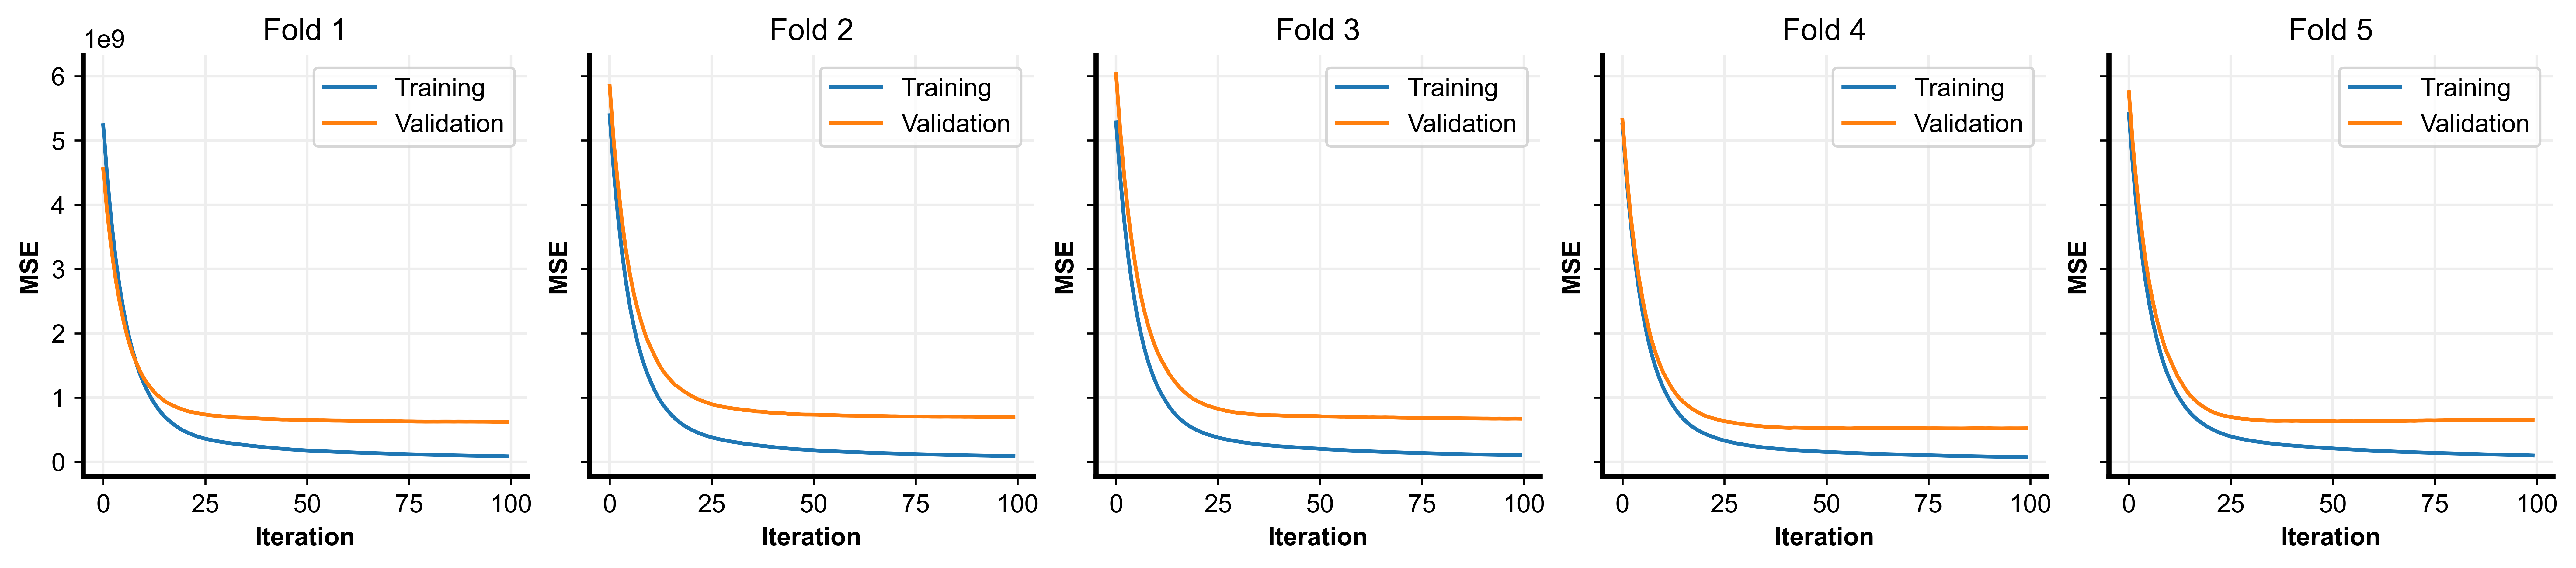

RMSE      MAE  MAPE    MBE  R^2
Baseline 25073.97 14911.17  8.82 117.47 0.90

In [6]:
plot_results(models)
plt.show()
display(results)

The model already converges quite well, even in the baseline version.

# Experiments

Let's try to push the performance of the model with everything that we learned during the data exploration.

## Encoder

Let's now try to add the next step: a custom encoder based on the documentation for the ordinal columns. In order to do so, we need to define a custom encoder class. This class functions also as an imputer for missing values, that in ordinal features will be set to 0.

In [7]:
cv = KFold()

y_pred = y_df.copy()
models = []

for train_i, test_i in cv.split(X_df):
    X_train_df, y_train_df = X_df.iloc[train_i, :], y_df.iloc[train_i]
    X_test_df, y_test_df = X_df.iloc[test_i, :], y_df.iloc[test_i]

    model = AmesRegressor(random_state=RANDOM_STATE, encode_ordinal=True)
    model.fit(X_train_df, y_train_df)

    y_pred.iloc[test_i] = model.predict(X_df.iloc[test_i, :])
    models += [model]

results.loc["Encoded"] = calculate_metrics(y_df, y_pred)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3543
[LightGBM] [Info] Number of data points in the train set: 1758, number of used features: 75
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 177883.897611
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3544
[LightGBM] [Info] Number of data points in the train set: 1758, number of used features: 74
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 18

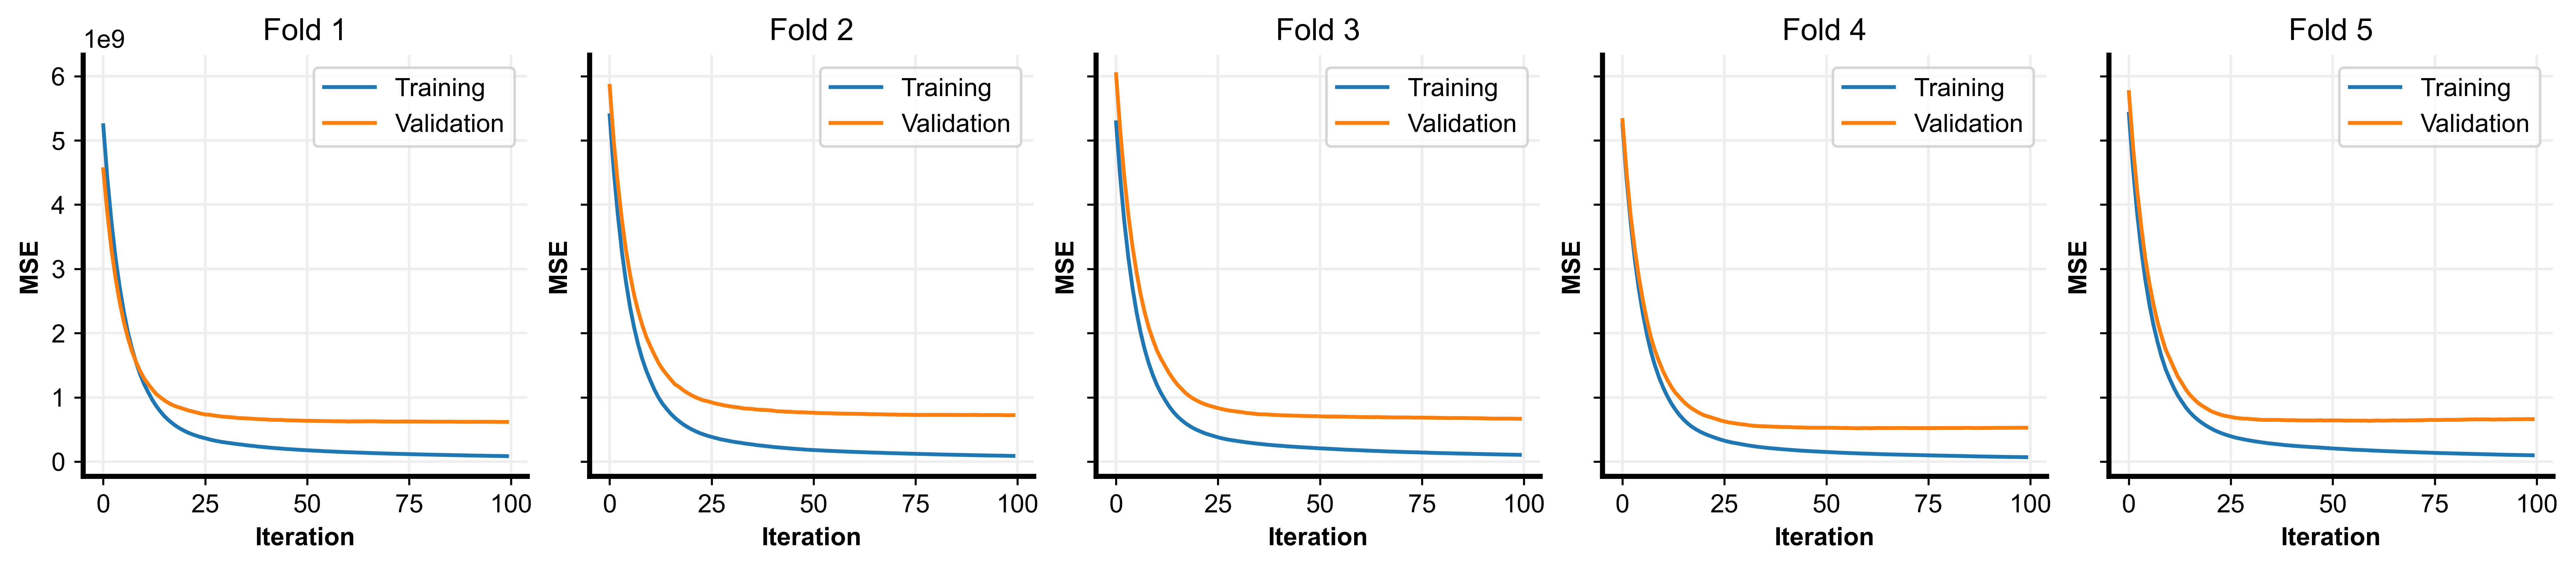

RMSE      MAE  MAPE    MBE  R^2
Baseline 25073.97 14911.17  8.82 117.47 0.90
Encoded  25063.80 14811.61  8.79 210.41 0.90

In [8]:
plot_results(models)
plt.show()
display(results)

There is already a noticeable improvement.

## Feature selection

Let's now try also eliminating the columns that in the analysis we thought as problematic.

In [9]:
cv = KFold()

y_pred = y_df.copy()
models = []

for train_i, test_i in cv.split(X_df):
    X_train_df, y_train_df = X_df.iloc[train_i, :], y_df.iloc[train_i]
    X_test_df, y_test_df = X_df.iloc[test_i, :], y_df.iloc[test_i]

    model = AmesRegressor(random_state=RANDOM_STATE, encode_ordinal=True, drop_problematic=True)
    model.fit(X_train_df, y_train_df)

    y_pred.iloc[test_i] = model.predict(X_df.iloc[test_i, :])
    models += [model]

results.loc["Selected"] = calculate_metrics(y_df, y_pred)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3205
[LightGBM] [Info] Number of data points in the train set: 1758, number of used features: 62
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 177883.897611
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3218
[LightGBM] [Info] Number of data points in the train set: 1758, number of used features: 62
[LightGBM] [Warning] Found whitespace in feature_names, replac

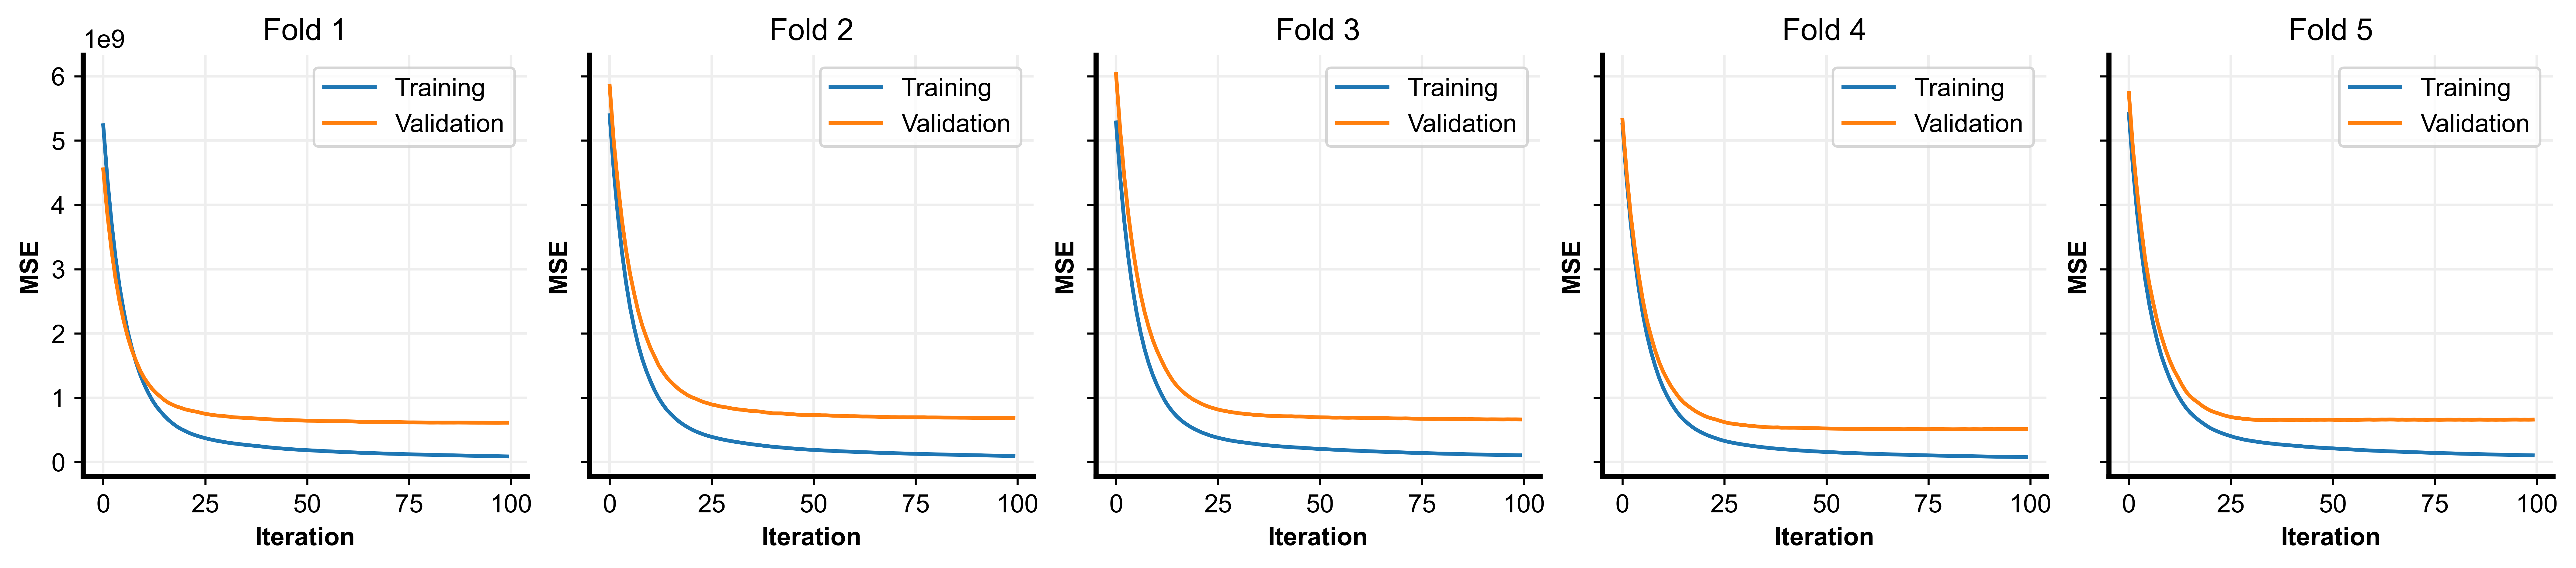

RMSE      MAE  MAPE    MBE  R^2
Baseline 25073.97 14911.17  8.82 117.47 0.90
Encoded  25063.80 14811.61  8.79 210.41 0.90
Selected 25109.34 14833.99  8.83  78.54 0.90

In [10]:
plot_results(models)
plt.show()
display(results)

By eliminating most of the problematic columns, the bias is now lower, without sacrificing too much RMSE and MAE.

## Parameter tuning

Let's add the final step to give the final performance boost: parameter tuning.

In [11]:
lgbm_params = {
    "random_state": RANDOM_STATE,
    "n_estimators": 20000,
    "num_leaves": 20,
    "max_depth": 3,
    "learning_rate": 0.01,
    "reg_alpha": 1e-3,
    "reg_lambda": 1e-2,
    "subsample": 0.8,
    "subsample_freq": 1,
    "n_jobs": -1,
}

cv = KFold()

y_pred = y_df.copy()
models = []

for train_i, test_i in cv.split(X_df):
    X_train_df, y_train_df = X_df.iloc[train_i, :], y_df.iloc[train_i]
    X_test_df, y_test_df = X_df.iloc[test_i, :], y_df.iloc[test_i]

    model = AmesRegressor(
        random_state=RANDOM_STATE,
        encode_ordinal=True,
        drop_problematic=True,
        lgbm_params=lgbm_params,
    )
    model.fit(X_train_df, y_train_df)

    y_pred.iloc[test_i] = model.predict(X_df.iloc[test_i, :])
    models += [model]

results.loc["Tuned"] = calculate_metrics(y_df, y_pred)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3205
[LightGBM] [Info] Number of data points in the train set: 1758, number of used features: 62
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 177883.897611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

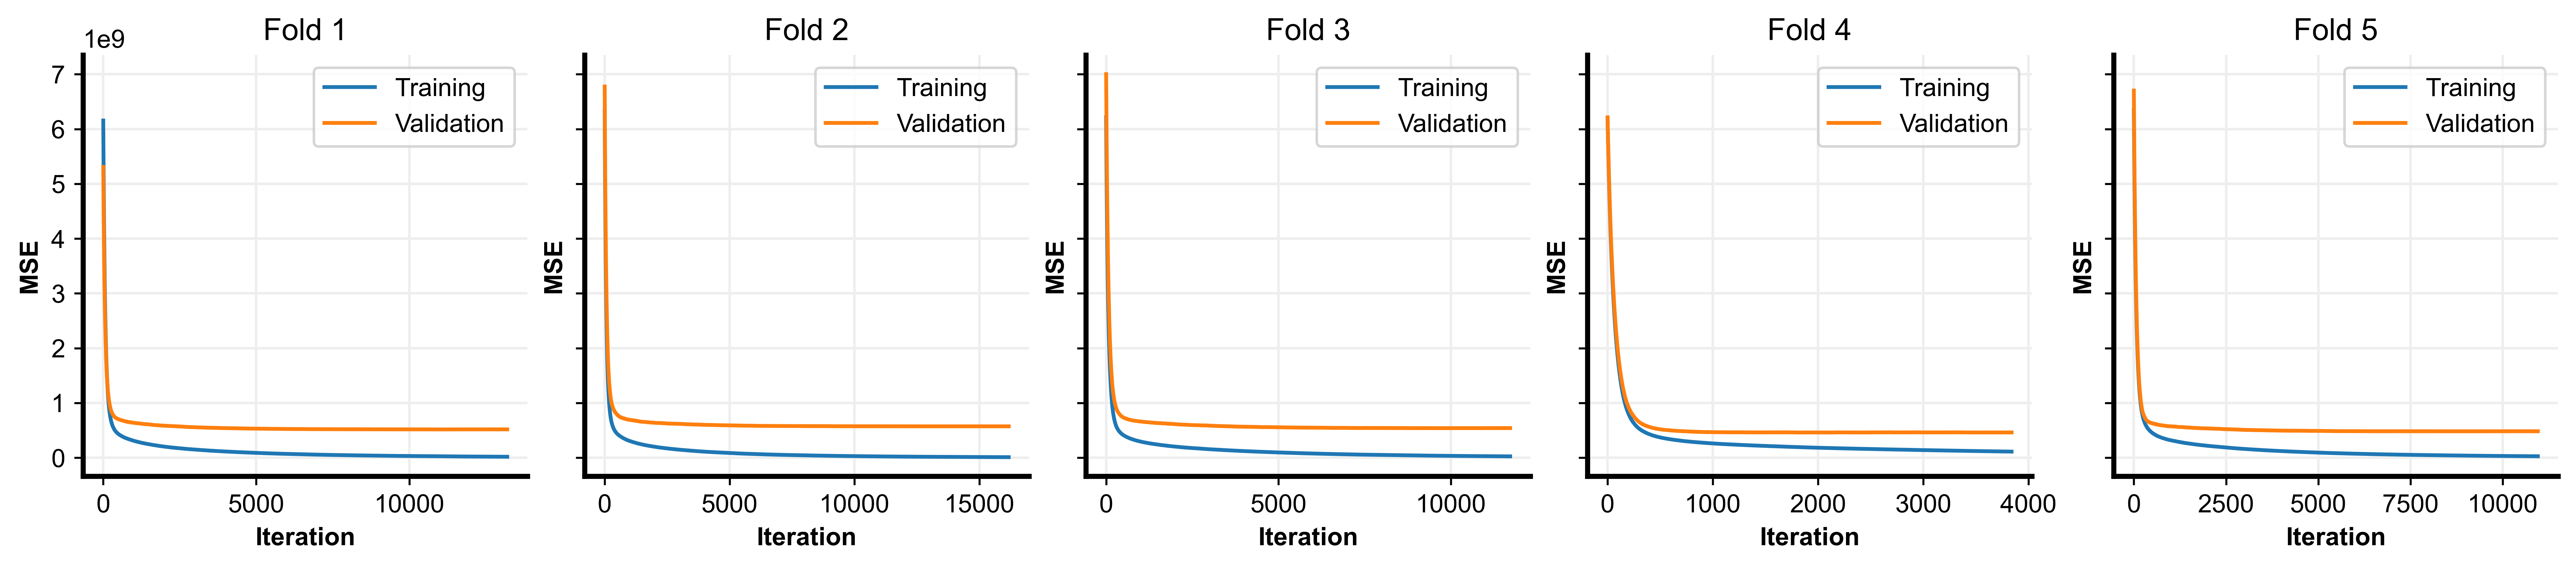

RMSE      MAE  MAPE    MBE  R^2
Baseline 25073.97 14911.17  8.82 117.47 0.90
Encoded  25063.80 14811.61  8.79 210.41 0.90
Selected 25109.34 14833.99  8.83  78.54 0.90
Tuned    24049.65 14249.25  8.46 104.27 0.91

In [12]:
plot_results(models)
plt.show()
display(results)